In [1]:
import torch
from torchvision import transforms
from dataset import NYUDataset
from custom_transforms import *
import plot_utils
import model_utils
from nn_model import Net
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline
import torch.nn.functional as F

In [2]:
#3x640x480 in dataset,   CxWxH
#480x640x3 for plotting, HxWxC
#3x480x640 for pytorch,  CxHxW  

In [2]:
bs = 8
sz = (320,240)
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
mean, std = torch.tensor(mean), torch.tensor(std)
unnormalize = UnNormalizeImgBatch(mean, std)

tfms = transforms.Compose([
    ResizeImgAndDepth(sz),
    RandomHorizontalFlip(),
    ImgAndDepthToTensor(),
    NormalizeImg(mean, std)
])

In [3]:
ds = NYUDataset('data/', tfms)
dl = torch.utils.data.DataLoader(ds, bs, shuffle=True)

In [ ]:
#i = 1
#plot_utils.plot_image(model_utils.get_unnormalized_ds_item(unnormalize, ds[i]))

#sample_batch = iter(dl).next()
#img, depth = sample_batch

In [ ]:
model = Net()
model.to(device)

In [5]:
model.load_state_dict(torch.load('all-scales-trained.ckpt'))
#model_utils.freeze_all_layers(model.VGG)
#model_utils.freeze_all_layers(model.Scale_1)
#model_utils.freeze_all_layers(model.Scale_2)

In [6]:
model.train()
n_epochs = 1
lr = 0.0000005
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = lr)

total_steps = 0
for e in range(n_epochs):
    for batch, labels in dl:
        optimizer.zero_grad()
        
        batch = batch.to(device)
        labels = labels.to(device)
        
        preds = model(batch)
        loss = model_utils.depth_loss(preds, labels) 
        
        loss.backward()
        optimizer.step()
        
        total_steps +=1
                                                       
        model_utils.print_training_loss_summary(loss.item(), total_steps, e+1, n_epochs, len(dl))

Epoch [1/1], Iteration [1/467], Loss: 1.2954
Epoch [1/1], Iteration [10/467], Loss: 1.5249
Epoch [1/1], Iteration [20/467], Loss: 1.1279
Epoch [1/1], Iteration [30/467], Loss: 1.4725
Epoch [1/1], Iteration [40/467], Loss: 1.4137
Epoch [1/1], Iteration [50/467], Loss: 2.0883
Epoch [1/1], Iteration [60/467], Loss: 2.0720
Epoch [1/1], Iteration [70/467], Loss: 1.2535
Epoch [1/1], Iteration [80/467], Loss: 2.0148
Epoch [1/1], Iteration [90/467], Loss: 1.2198
Epoch [1/1], Iteration [100/467], Loss: 1.3530
Epoch [1/1], Iteration [110/467], Loss: 1.3991
Epoch [1/1], Iteration [120/467], Loss: 1.7189
Epoch [1/1], Iteration [130/467], Loss: 2.0150
Epoch [1/1], Iteration [140/467], Loss: 1.6647
Epoch [1/1], Iteration [150/467], Loss: 1.0784
Epoch [1/1], Iteration [160/467], Loss: 1.8906
Epoch [1/1], Iteration [170/467], Loss: 1.3315
Epoch [1/1], Iteration [180/467], Loss: 1.3844
Epoch [1/1], Iteration [190/467], Loss: 1.8716
Epoch [1/1], Iteration [200/467], Loss: 1.2280
Epoch [1/1], Iteration [

In [15]:
torch.save(model.state_dict(),'all-scales-trained.ckpt')

In [7]:
%%time
with torch.no_grad():
    model.eval()
    img, depth = iter(dl).next()
    preds = model(img.to(device))

CPU times: user 336 ms, sys: 0 ns, total: 336 ms
Wall time: 206 ms


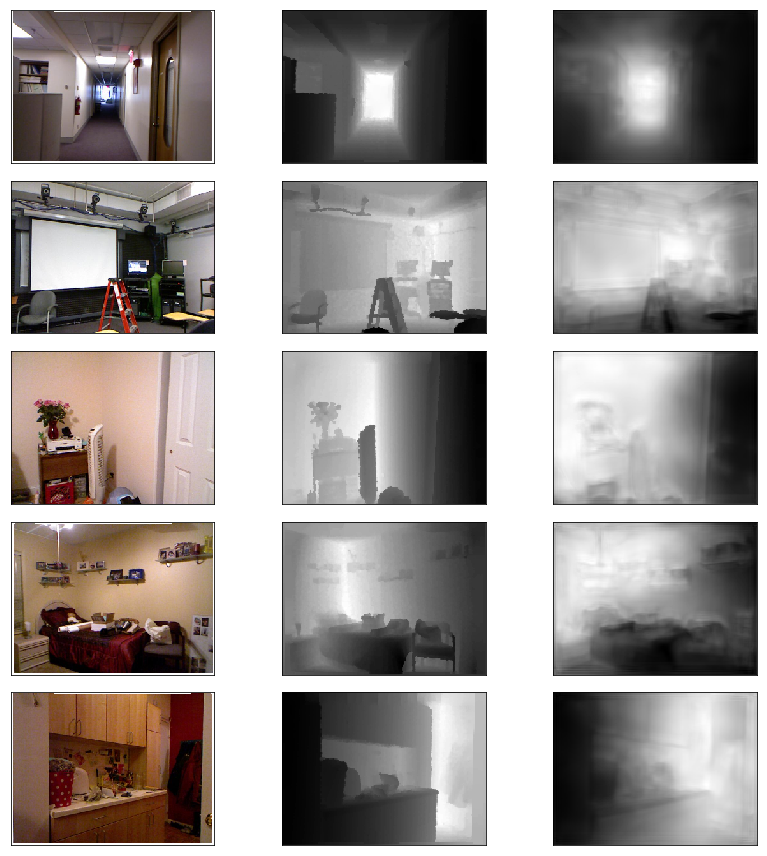

In [18]:
plot_utils.plot_model_predictions_on_sample_batch(images=unnormalize(img), depths=depth, preds=preds.squeeze(dim=1), plot_from=0)

In [11]:
import matplotlib.pyplot as plt
def plot_test_depth(pred):
    fig, ax = plt.subplots(1, 1, figsize=(10,15))
    plot_utils.plot_depth_tensor_in_subplot(ax, pred.detach().squeeze(dim=1).squeeze(dim=0))
    plot_utils.hide_subplot_axes(ax)
    plt.tight_layout()
    
test_tfms = transforms.Compose([
    transforms.Scale(sz),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [12]:
im = Image.open('IMG_4122.jpg').rotate(180)
res = test_tfms(im)
pred = model(res[None].to(device))

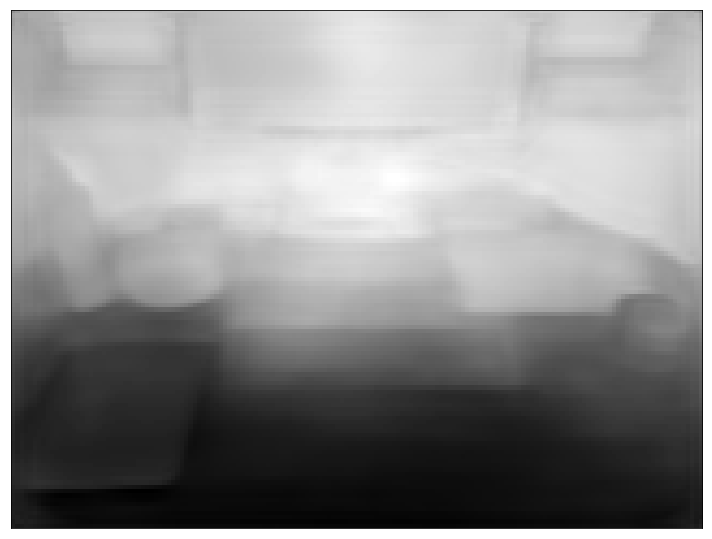

In [13]:
plot_test_depth(pred)

In [14]:
T, P = transforms.ToTensor(), transforms.ToPILImage()
dx, dy, g = model_utils.apply_sobel_operator_on_sample_ds_image(ds[10], unnormalize, T, P)

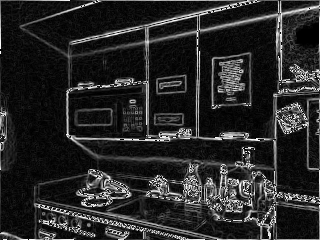

In [14]:
P(g)

In [1]:
from IPython.display import FileLink
FileLink('all-scales-trained.ckpt')

/home/paperspace/nyu/all-scales-trained.ckpt